In [49]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
#from keras import ops
import tensorflow as tf

#import cv2|
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

## TRAIN, TEST AND VALIDATION DATA COLLECTION(FUNDUS_PYTORCH)

In [101]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/fundus-pytorch/train"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_train = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_train.to_csv("train.csv", index=False)

#####################################################################################################
# Directory containing the images
test_dir = "/kaggle/input/fundus-pytorch/test"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(test_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_test = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_test.to_csv("test.csv", index=False)
##########################################################################################

# Directory containing the images
valid_dir = "/kaggle/input/fundus-pytorch/val"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(valid_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_valid = pd.DataFrame(data, columns=["file_path", "label"])

# Save the DataFrame to a CSV file
df_valid.to_csv("valid.csv", index=False)


In [102]:
df_train.count()

file_path    8621
label        8621
dtype: int64

## GLAUCOMA_DATASET

In [103]:


# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/glaucoma-datasets/G1020/G1020.csv')

# Create a new DataFrame with the image names and labels
df_train1 = pd.DataFrame({
    'file_path': ['/kaggle/input/glaucoma-datasets/G1020/Images/' + image_id for image_id in df['imageID']],
    'label': df['binaryLabels']
})

# Display the first few rows of the new DataFrame
print(df_train1.head())


                                           file_path  label
0  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
1  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
2  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
3  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
4  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0


## ORIGA_DATASET

In [105]:


# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/glaucoma-datasets/ORIGA/OrigaList.csv')

# Create a new DataFrame with the image names and labels
df_train2 = pd.DataFrame({
    'file_path': ['/kaggle/input/glaucoma-datasets/ORIGA/Images/' + image_id for image_id in df['Filename']],
    'label': df['Glaucoma']
})

# Display the first few rows of the new DataFrame
print(df_train2.head())


                                           file_path  label
0  /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
1  /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
2  /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
3  /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
4  /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0


In [106]:
df_train2.head()

,file_path,label
0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...,0
1,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...,0
2,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...,0
3,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...,0
4,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...,0


In [107]:
import pandas as pd

# Assuming df_train and df_train1 are already defined

# Stack the dataframes
df_train = pd.concat([df_train, df_train1, df_train2], ignore_index=True)

# Display the first few rows of the new DataFrame
print(df_train.head())


                                           file_path  label
0  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
1  /kaggle/input/fundus-pytorch/train/0/REFUGE1-t...      0
2  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
3  /kaggle/input/fundus-pytorch/train/0/PAPILA-38...      0
4  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0


## RESIZING THE IMAGES

In [108]:
# Create a new directory in /kaggle/working/
new_directory = '/kaggle/working/resized_images'
os.makedirs(new_directory, exist_ok=True)

# Initialize a list to store the resized file paths
resized_file_paths = []

# Loop through each row in df_train
for index, row in df_train.iterrows():
    # Load the image
    image = cv2.imread(row['file_path'])
    # Check if the image is None
    if image is None:
        print(f"Failed to read image: {row['file_path']}")
    else:
        # Resize the image to 512x512
        resized_image = cv2.resize(image, (512, 512))
        # Generate a new file path for the resized image
        resized_file_path = f'{new_directory}/{row["file_path"].split("/")[-1][:-4]}_resized.png'
        # Save the resized image to the new file path
        cv2.imwrite(resized_file_path, resized_image)
        # Append the new file path to the list
        resized_file_paths.append(resized_file_path)

# Update the 'file_path' column in df_train with the new file paths
df_train['file_path'] = resized_file_paths

# Print the first few rows of df_train to verify the changes
print(df_train.head())

                                           file_path  label
0  /kaggle/working/resized_images/OIA-ODIR-TEST-O...      0
1  /kaggle/working/resized_images/REFUGE1-train-2...      0
2  /kaggle/working/resized_images/OIA-ODIR-TRAIN-...      0
3  /kaggle/working/resized_images/PAPILA-387_resi...      0
4  /kaggle/working/resized_images/OIA-ODIR-TRAIN-...      0


In [109]:
df_train.head()

,file_path,label
0,/kaggle/working/resized_images/OIA-ODIR-TEST-O...,0
1,/kaggle/working/resized_images/REFUGE1-train-2...,0
2,/kaggle/working/resized_images/OIA-ODIR-TRAIN-...,0
3,/kaggle/working/resized_images/PAPILA-387_resi...,0
4,/kaggle/working/resized_images/OIA-ODIR-TRAIN-...,0


### IMAGE SIZE CHECK

In [119]:
import os
import cv2

# Path to the directory where the resized images are saved
resized_images_directory = '/kaggle/working/resized_images'

# Get the list of files in the directory
image_files = os.listdir(resized_images_directory)

# Initialize a list to store the image sizes
image_sizes = []

# Loop through each image file
for image_file in image_files:
    # Construct the full file path
    file_path = os.path.join(resized_images_directory, image_file)
    # Read the image
    image = cv2.imread(file_path)
    # Get the image size
    image_size = image.shape[:2]
    # Append the image size to the list
    image_sizes.append((image_file, image_size))

# Print the image sizes
for image_file, image_size in image_sizes:
    print(f"Image: {image_file}, Size: {image_size}")


Image: OIA-ODIR-TRAIN-2638_resized.png, Size: (512, 512)
Image: 309_resized.png, Size: (512, 512)
Image: image_1713_resized.png, Size: (512, 512)
Image: 397_resized.png, Size: (512, 512)
Image: EyePACS-Glaucoma-2891_resized.png, Size: (512, 512)
Image: FIVES-175_resized.png, Size: (512, 512)
Image: OIA-ODIR-TEST-ONLINE-869_resized.png, Size: (512, 512)
Image: image_3130_resized.png, Size: (512, 512)
Image: sjchoi86-HRF-122_resized.png, Size: (512, 512)
Image: sjchoi86-HRF-170_resized.png, Size: (512, 512)
Image: BEH-390_resized.png, Size: (512, 512)
Image: OIA-ODIR-TRAIN-1644_resized.png, Size: (512, 512)
Image: 602_resized.png, Size: (512, 512)
Image: BEH-389_resized.png, Size: (512, 512)
Image: OIA-ODIR-TRAIN-3028_resized.png, Size: (512, 512)
Image: EyePACS-Glaucoma-1785_resized.png, Size: (512, 512)
Image: OIA-ODIR-TEST-ONLINE-8_resized.png, Size: (512, 512)
Image: FIVES-7_resized.png, Size: (512, 512)
Image: EyePACS-Glaucoma-550_resized.png, Size: (512, 512)
Image: sjchoi86-HRF-12

## REGION OF INTEREST EXTRACTION

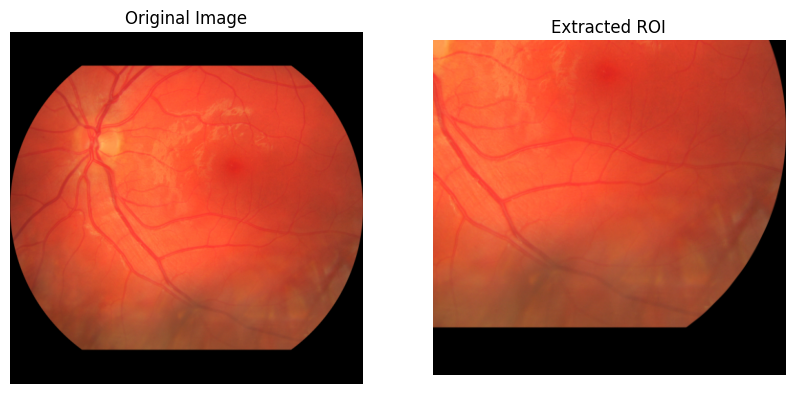

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train["file_path"].sample().values[0]
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 6 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Crop the image
roi_image = image[y:y+512, x:x+512]

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()


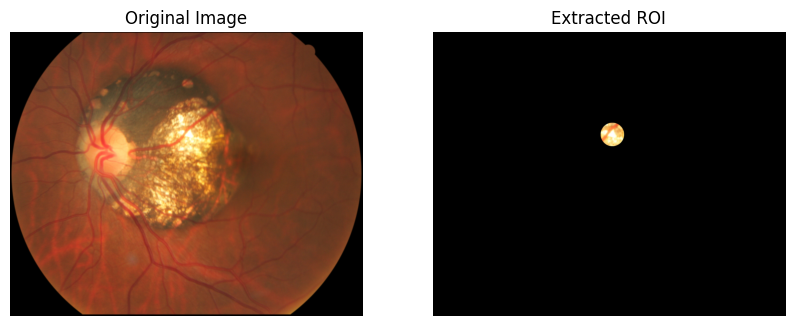

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train1["file_path"].sample().values[0]
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 200 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Create a mask for the circle
mask = np.zeros_like(image)
cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

# Apply the mask to the original image
roi_image = cv2.bitwise_and(image, mask)

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()



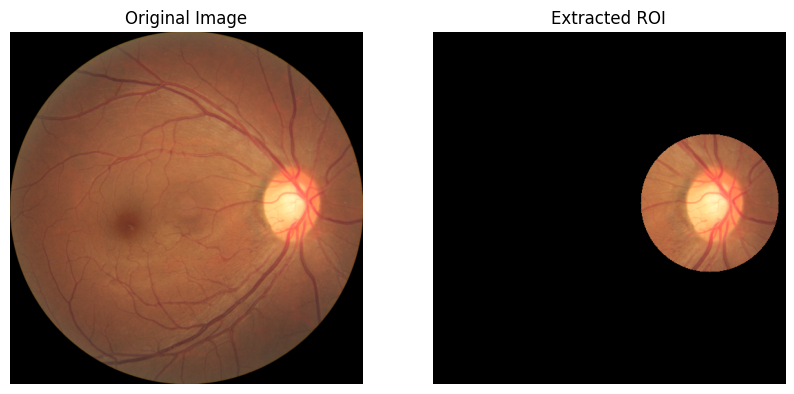

In [159]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train["file_path"].sample().values[0]

# Check the file extension
file_extension = os.path.splitext(image_path)[1]

# Load the image based on the file extension
if file_extension.lower() == '.png':
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
else:
    image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 200 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Create a mask for the circle
mask = np.zeros_like(image)
cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

# Apply the mask to the original image
roi_image = cv2.bitwise_and(image, mask)

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()


## PERFORM ROI ON THE DATA

In [160]:
import cv2
import numpy as np
import os
import pandas as pd

def extract_rois_and_labels(df, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize an empty list to store the rows of the DataFrame
    roi_rows = []
    
    for index, row in df.iterrows():
        # Load the image
        image = cv2.imread(row['file_path'])
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)
        
        # Find the pixel with the highest intensity value
        max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)
        
        # Define the radius for the circle
        radius = 200 // 2
        
        # Get the x and y coordinates for cropping the image
        x = max_intensity_pixel[1] - radius
        y = max_intensity_pixel[0] - radius
        
        # Create a mask for the circle
        mask = np.zeros_like(image)
        cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)
        
        # Apply the mask to the original image
        roi_image = cv2.bitwise_and(image, mask)
        
        # Save the ROI image
        roi_filename = os.path.basename(row['file_path']).split('.')[0] + '_roi.jpg'
        roi_path = os.path.join(output_dir, roi_filename)
        cv2.imwrite(roi_path, roi_image)
        
        # Append the row to the list
        roi_rows.append({'roi_path': roi_path, 'label': row['label']})
    
    # Create a DataFrame from the list of rows
    roi_df = pd.DataFrame(roi_rows)
    
    return roi_df




###### PROCESSOR INTENSIVE CODE

In [161]:
# Extract ROIs and labels for the training images
train_roi_df = extract_rois_and_labels(df_train, 'train_roi_images')

# Extract ROIs and labels for the testing images
test_roi_df = extract_rois_and_labels(df_test, 'test_roi_images')

# Extract ROIs and labels for the validation images
valid_roi_df = extract_rois_and_labels(df_valid, 'valid_roi_images')

###### PLOT OF THE NEW DATAFRAMES

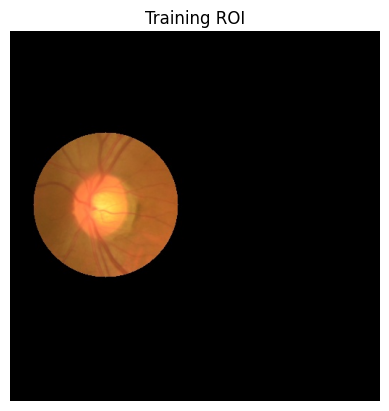

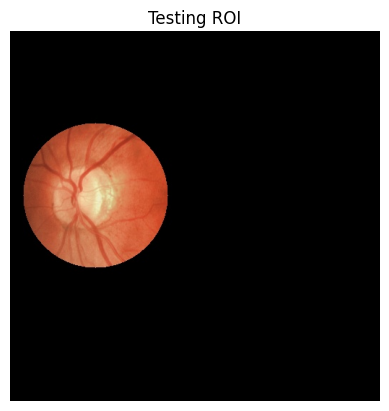

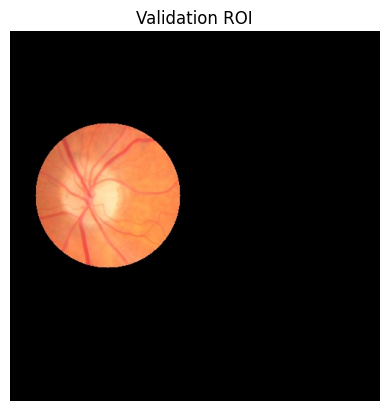

In [162]:
import matplotlib.pyplot as plt
import random

# Function to plot a random image from a DataFrame
def plot_random_image(df, title):
    # Get a random row from the DataFrame
    random_row = df.sample()
    
    # Load the image
    image_path = random_row['roi_path'].values[0]
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot a random image from each DataFrame
plot_random_image(train_roi_df, 'Training ROI')
plot_random_image(test_roi_df, 'Testing ROI')
plot_random_image(valid_roi_df, 'Validation ROI')


In [163]:
train_roi_df.label.count()

10291

# DATA PREPROCESSING

In [166]:
# Convert the label column to strings
train_roi_df["label"] = train_roi_df["label"].astype(str)
test_roi_df["label"] = test_roi_df["label"].astype(str)
valid_roi_df["label"] = valid_roi_df["label"].astype(str)

In [183]:
train_roi_df["label"].value_counts()

label
0    6499
1    3792
Name: count, dtype: int64

In [167]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define the data generator for validation images
valid_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Create the validation data generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
)

# Define the data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)


Found 10291 validated image filenames belonging to 2 classes.
Found 5747 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.


## BUILDING U_NET ARCHITECTURE

In [168]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.metrics import AUC

# def build_unet_model(input_shape):
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # Encoder
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     # Bottleneck
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
#     # Decoder
#     up4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
#     merge4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
#     up5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
#     merge5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
#     # Output
#     outputs = layers.Conv2D(1, 1, activation='softmax')(conv5)
    
#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")
    
#     return model

# # Create the U-Net model
# unet_model = build_unet_model(input_shape=(256, 256, 3))

# # Compile the model with SGD optimizer
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)

In [169]:
# unet_model.summary()

In [170]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

### BUILDING NORMAL CNN ARCHITECTURE

In [184]:

import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import Loss

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
#     Dropout(0.5),  # Add dropout layer
    Dense(1, activation='sigmoid')
])
# NO DROPOUT LAYER FOR 0.83

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, #LEARNING RATE TO 0.01 FOR 0.83
                                        momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)


class FocalLoss(Loss):
    def __init__(self, alpha=0.65, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Calculate binary cross-entropy loss
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)

        # Calculate focal loss
        pt = tf.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        # Calculate class weights
        class_weights = tf.constant([1.0, 1.0])  # Initialize with equal weights
        total_samples = tf.reduce_sum(y_true)
        class_weights = total_samples / (2.0 * tf.reduce_sum(y_true, axis=0))

        # Apply class weights to the focal loss
        focal_loss = focal_loss * class_weights

        return focal_loss



# Compile the model
model.compile(optimizer=sgd_optimizer,
              loss=FocalLoss(),
              metrics=[AUC()])

#CHANGE TO AUC FOR 0.83

In [185]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

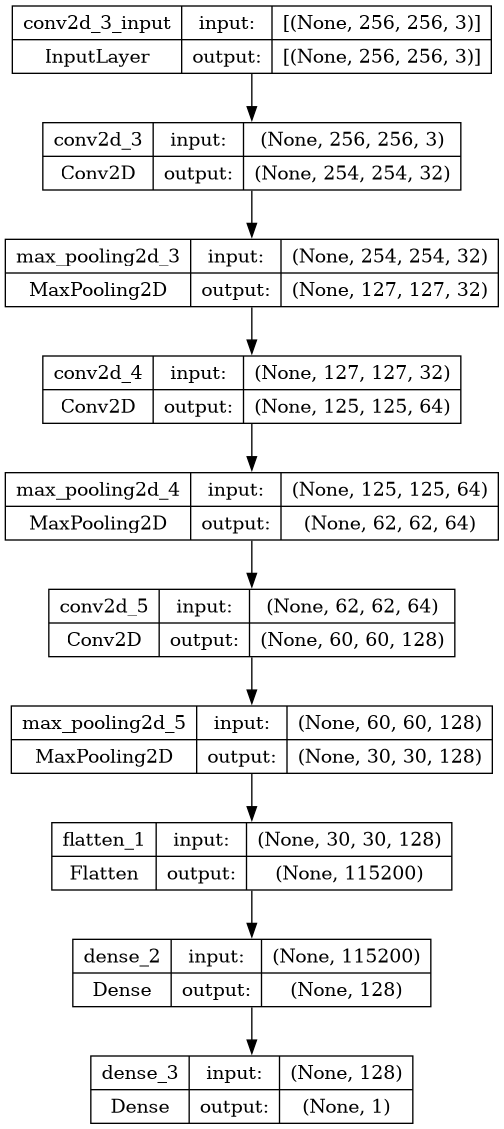

In [186]:
tf.keras.utils.plot_model(model, show_shapes=True)

###### DEALING WITH CLASS IMBALANCE AND OVER FITTING

In [187]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)


In [189]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
322/322 [==============================] - 39s 121ms/step - loss: 0.0393 - auc_1: 0.8315 - val_loss: 0.0384 - val_auc_1: 0.8558 - lr: 0.0100
Epoch 2/30
322/322 [==============================] - 39s 121ms/step - loss: 0.0394 - auc_1: 0.8327 - val_loss: 0.0369 - val_auc_1: 0.8634 - lr: 0.0100
Epoch 3/30
322/322 [==============================] - 38s 118ms/step - loss: 0.0388 - auc_1: 0.8384 - val_loss: 0.0376 - val_auc_1: 0.8689 - lr: 0.0100
Epoch 4/30
322/322 [==============================] - 39s 120ms/step - loss: 0.0385 - auc_1: 0.8429 - val_loss: 0.0362 - val_auc_1: 0.8764 - lr: 0.0100
Epoch 5/30
322/322 [==============================] - 36s 113ms/step - loss: 0.0383 - auc_1: 0.8449 - val_loss: 0.0344 - val_auc_1: 0.8904 - lr: 0.0100
Epoch 6/30
322/322 [==============================] - 38s 119ms/step - loss: 0.0378 - auc_1: 0.8471 - val_loss: 0.0345 - val_auc_1: 0.8835 - lr: 0.0100
Epoch 7/30
322/322 [==============================] - 39s 120ms/step - loss: 0.0376 - au

# MODEL EVALUATION

In [190]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test accuracy: {test_acc}")

90/90 - 6s - loss: nan - auc_1: 0.8906 - 6s/epoch - 67ms/step
Test accuracy: 0.8906104564666748


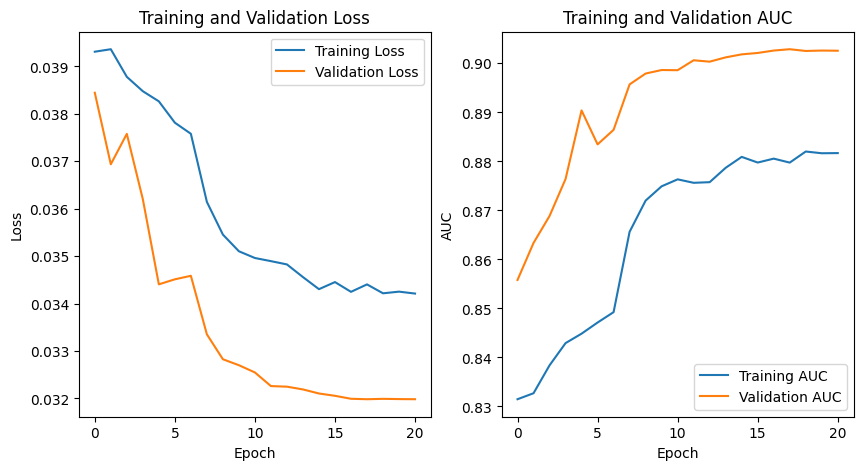

In [192]:
import matplotlib.pyplot as plt

# Get the training and validation loss and AUC scores from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_1']
val_auc = history.history['val_auc_1']

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create a plot of the training and validation AUC scores
plt.subplot(1, 2, 2)
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.show()


90/90 [==============================] - 6s 64ms/step


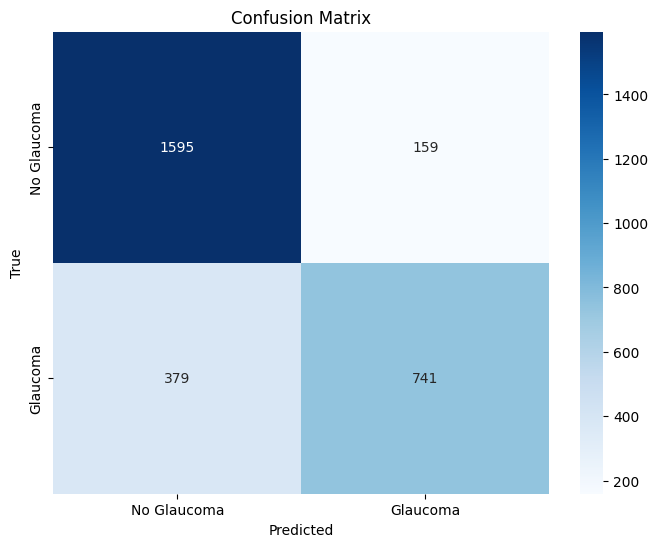

In [193]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Convert the predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Glaucoma', 'Glaucoma'], yticklabels=['No Glaucoma', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


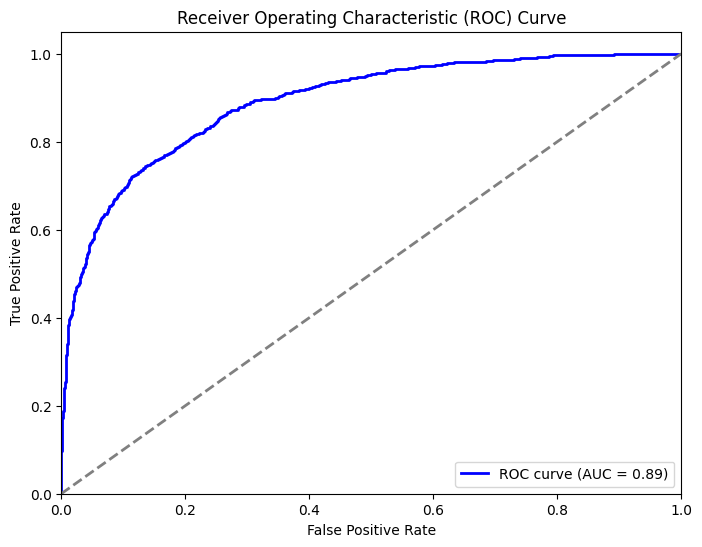

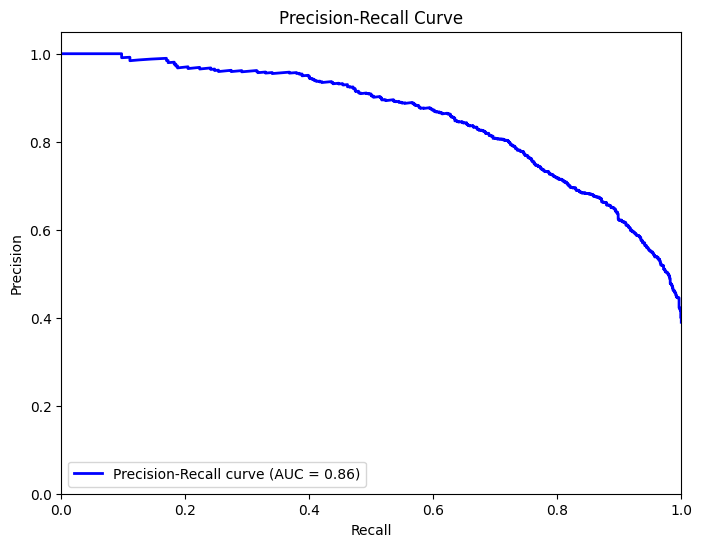

In [179]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# SAVE MODEL

In [ ]:
model.save('GLAUCOMA_DETECTION.h5')